# Figure 4: Type of epistasis arising from the ensemble depends on mutational effects

## Imports

In [13]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import matplotlib

# Some pretty plot defaults
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False



matplotlib.rcParams['axes.labelsize'] = 25
matplotlib.rcParams['axes.titlesize'] = 30
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

## Functions

In [14]:
def en(G_j,G_k,T=298,R=0.001987):
    """
    Boltzmann-weighted free energy of conformations j and k.
    
    G_j: stability of conformation j
    G_k: stability of conformation k
    T: temperature (K)
    R: gas constant (kcal/K*mol)"""
    
    RT = R*T

    return -RT*np.log(np.exp(-G_j/RT) + np.exp(-G_k/RT))


def get_epistasis(G_i,G_j,G_k,             
                  dG_i_A,dG_j_A,dG_k_A,
                  dG_i_B,dG_j_B,dG_k_B,
                  T=298,R=0.001987):
    """
    Return the epistasis in dG_obs between two mutations introduced into a
    three-conformation system. 
    
    G_i, G_j, G_k: G of conformations i, j, and k for genotype ab
    dG_i_A, dG_j_A, dG_k_A: effect of mutation A on conformations i, j, and k
    dG_i_B, dG_j_B, dG_k_B: effect of mutation B on conformations i, j, and k
    T: temperature (K)
    R: gas constant  (kcal/K*mol)
    
    returns:
        magnitude of epistasis (sign is (AB - aB) - (Ab - ab))
        whether sign in A (True,False)
        whether sign in B (Ture,False)
        type of epistasis as a string (none, magnitude, sign, reciprocal_sign)
    """
    ###################################################################################################
    # observables
    ###################################################################################################
    ab = G_i                   - en(G_j,                   G_k,                   T,R)
    Ab = G_i + dG_i_A          - en(G_j + dG_j_A,          G_k + dG_k_A,          T,R)
    aB = G_i +          dG_i_B - en(G_j +          dG_j_B, G_k +          dG_k_B, T,R)
    AB = G_i + dG_i_A + dG_i_B - en(G_j + dG_j_A + dG_j_B, G_k + dG_k_A + dG_k_B, T,R)
 
    ###################################################################################################
    # magnitude
    ###################################################################################################
    mag_in_a = (AB - aB) - (Ab - ab)
    mag_in_b = (AB - Ab) - (aB - ab)
    if mag_in_a == 0:
        return mag_in_a, mag_in_b, False, False, "none"

    ep_type = "magnitude"
    ###################################################################################################
    # sign in A
    ###################################################################################################
    s1 = (AB - aB)/np.abs(AB - aB)
    s2 = (Ab - ab)/np.abs(Ab - ab)
    sign_in_a = False
    
    if s1 != s2:
        ep_type = "sign"
        sign_in_a = True
    ###################################################################################################
    # sign in B
    ###################################################################################################
    s1 = (AB - Ab)/np.abs(AB - Ab)
    s2 = (aB - ab)/np.abs(aB - ab)
    sign_in_b = False
    if s1 != s2:
        ep_type = "sign"
        sign_in_b = True
    ###################################################################################################
    # reciprocal
    ###################################################################################################
    if sign_in_a and sign_in_b:
        ep_type = "reciprocal_sign"
    
    return mag_in_a, mag_in_b, sign_in_a, sign_in_b, ep_type



def plot_surface(some_array,x_array,y_array,flip_color=True,max_value=None,cmap="bwr",
                 xlabel=None,ylabel=None):
    """
    Plot a contour map.
    
    some_array: n x m 2D array
    x_array: array with (at least) [min_x,max_x]
    y_array: array with (at least) [min_y,max_y]
    flip_color: whether or not to flip values in some_array before plotting
    max_value: set min and max color to -max_value and +max_value
        None: get max_value from the array by max(abs(some_array))
        float: use abs(max_value) given
    cmap: matplotlib color map to use
    xlabel: x label
    ylabel: y label
    """
    ###################################################################################################
    # Flip color
    ###################################################################################################
    if flip_color:
        plot_array = -some_array

    else:
        plot_array = some_array
    ###################################################################################################
    # Set max color
    ###################################################################################################
    if max_value is None:
        extreme = np.max(np.abs(plot_array))

    else:
        extreme = np.abs(max_value)
    print(extreme)
    ###################################################################################################
    # Plot it
    ###################################################################################################
    plt.imshow(plot_array,
               cmap=cmap,origin="lower",vmin=-extreme,vmax=extreme,
               extent=[x_array[0],x_array[-1],y_array[0],y_array[-1],],
               interpolation="none")
    
    if xlabel is not None:
        plt.xlabel(xlabel)
    
    if ylabel is not None:
        plt.ylabel(ylabel)
        
        
def _plot_states(G_j,
                 G_k,
                 dG_j=None,
                 dG_k=None,
                 observable=0,
                 x_location=0,arrow_colors=None):
    """
    Draw conformation energies and effects of mutations for a given genotype.
    
    G_j: stability of conformation j before mutation
    G_k: stability of conformation k before mutation
    dG_j: effect of mutations to conformation j.  
           If None, no mutations.
           If float, single mutation (one arrow).
           If list of floats, multiple mutations (each with own arrow)
    dG_k: effect of mutations to conformation k.  (Same syntax as ddG_j).
    observable: observable <dGjk>
    x_location: where to draw states on total plot.
    arrow_colors: color to draw each arrow.
                  If None, all arrows black.
                  Otherwise, must be a list of colors, in order.  Arrows are
                  plotted in order ddG_j, then ddG_k.   
    """
    ###################################################################################################
    # x-placement for edges of genotypes
    ###################################################################################################
    x0 = 0
    x1 = 2
    x2 = 2.5
    x3 = 4.5
    ###################################################################################################
    # If dG_j specified, add dashed line for G_j
    ###################################################################################################
    if dG_j is None:
        dG_j = 0
    else:        
        plt.plot([x0+x_location,x1+x_location],[G_j,G_j],"--",lw=2,color="purple",zorder=10)
    ###################################################################################################
    # If dG_k specified, add dashed line for G_k
    ###################################################################################################
    if dG_k is None:
        dG_k = 0
    else:        
        plt.plot([x2+x_location,x3+x_location],[G_k,G_k],"--",lw=2,color="blue",zorder=10)
    
    
    
    ###################################################################################################
    # If dG_j is a list, grab total shift.  If it is not a list, treat as total 
    # shift and turn into a list.
    ###################################################################################################
    try:
        len(dG_j)
        total_dG_j = sum(dG_j)
    except TypeError:
        total_dG_j = dG_j
        dG_j = [dG_j,]

    ###################################################################################################
    # If dG_k is a list, grab total shift.  If it is not a list, treat as total 
    # shift and turn into a list.
    ###################################################################################################
    try:
        len(dG_k)
        total_dG_k = sum(dG_k)
    except TypeError:
        total_dG_k = dG_k
        dG_k = [dG_k,]
    
    ###################################################################################################
    # Plot energy levels
    ###################################################################################################
    plt.plot([x0 + x_location, x1 + x_location],[G_j+total_dG_j, G_j+total_dG_j],
             lw=2, color="purple", zorder=10)
    plt.plot([x2 + x_location, x3 + x_location],[G_k+total_dG_k, G_k+total_dG_k], 
             lw=2, color="blue", zorder=10)
    
    ###################################################################################################
    # Plot observable
    ###################################################################################################
    plt.plot([x0 + x_location, x3 + x_location], [observable, observable],
             lw=4, color="black", zorder=0)
    
    
    ###################################################################################################
    # Count through arrow colors
    ###################################################################################################
    color_counter = 0
    
    ###################################################################################################
    ###################################################################################################
    current = G_j
    for counter, j_arrow in enumerate(dG_j):
        
        # If this ddG is 0, do not draw an arrow
        if j_arrow == 0:
            continue
        
        # Figure out where to draw arrow (x-position)
        x = x0 + (x1 - x0)/2 + x_location
    
        # Figure out if arrow goes up or down
        sign = j_arrow/np.abs(j_arrow)
        
        # Figure out arrow color
        if arrow_colors is not None:
            c = arrow_colors[color_counter]
        else:
            c = "black"
        
        # Draw arrow
        plt.arrow(x,current,0,j_arrow -sign*0.25,color=c,width=0.2,head_length=0.50,zorder=20)
        
        # Update counters
        current = current + j_arrow
        color_counter += 1
        
    ###################################################################################################
    ###################################################################################################
    current = G_k
    for counter, k_arrow in enumerate(dG_k):
        
        # If this ddG is 0, do not draw an arrow
        if k_arrow == 0:
            continue
        
        # Figure out where to draw arrow (x-position)
        x = x2 + (x3 - x2)/2 + x_location
    
        # Figure out if arrow goes up or down
        sign = k_arrow/np.abs(k_arrow)
        
        # Figure out arrow color
        if arrow_colors is not None:
            c = arrow_colors[color_counter]
        else:
            c = "black"
        ###################################################################################################
        # Draw arrow
        ###################################################################################################
        plt.arrow(x,current,0,k_arrow -sign*0.25,color=c,width=0.2,head_length=0.50,zorder=20)
        
        ###################################################################################################
        # Update counters
        ###################################################################################################
        current = current + k_arrow
        color_counter += 1
        

    

def plot_state_cycle(G_j=0,G_k=0,
                     dG_Aj=-4,dG_Ak=4,
                     dG_Bj=-4,dG_Bk=4,
                     T=298,R=0.001987,
                     ylim=(-14,14)):
    """
    dG_j: stability of conformation j, ab genotype
    dG_k: stability of conformation k, ab genotype
    ddG_Aj: effect of mutation A on conformation j
    ddG_Ak: effect of mutation A on conformation k
    ddG_Bj: effect of mutation B on conformation j
    ddG_Bk: effect of mutation B on conformation k
    T: temperature (K)
    R: gas constant  (kcal/K*mol)
    y_lim: y-limits of plot
    """
    ###################################################################################################
    # Calculate observables for ab, Ab, aB, and AB genotypes
    RT = R*T
    
    ab = en(G_j                 ,  G_k,                  T,R)
    Ab = en(G_j + dG_Aj         ,  G_k + dG_Ak,          T,R)
    aB = en(G_j          + dG_Bj,  G_k          + dG_Bk, T,R)
    AB = en(G_j + dG_Aj + dG_Bj ,  G_k + dG_Ak  + dG_Bk, T,R)
    ###################################################################################################
    ###################################################################################################
    # print relative populations
    ###################################################################################################
    print('pop-ab, j: ' , np.exp(-G_j)/(np.exp(-G_j) + np.exp(-G_k)))
    print('pop-ab, k: ' , np.exp(-G_k)/(np.exp(-G_j) + np.exp(-G_k)), '\n')
    
    print('pop-Ab, j: ' , np.exp(-(G_j + dG_Aj))/(np.exp(-(G_j + dG_Aj)) + np.exp(-(G_k + dG_Ak))))
    print('pop-Ab, k: ' , np.exp(-(G_k + dG_Ak))/(np.exp(-(G_j + dG_Aj)) + np.exp(-(G_k + dG_Ak))), '\n')
    
    print('pop-aB, j: ' , np.exp(-(G_j + dG_Bj))/(np.exp(-(G_j + dG_Bj)) + np.exp(-(G_k + dG_Bk))))
    print('pop-aB, k: ' , np.exp(-(G_k + dG_Bk))/(np.exp(-(G_j + dG_Bj)) + np.exp(-(G_k + dG_Bk))), '\n')

    print('pop-AB, j: ' , np.exp(-(G_j + dG_Aj + dG_Bj))/(np.exp(-(G_j + dG_Aj + dG_Bj)) + np.exp(-(G_k + dG_Ak +  dG_Bk))))
    print('pop-AB, k: ' , np.exp(-(G_k + dG_Ak + dG_Bk))/(np.exp(-(G_j + dG_Aj + dG_Bj)) + np.exp(-(G_k + dG_Ak +  dG_Bk))), '\n')

    
    ###################################################################################################
    # Plot states for each genotype, offseting by x_location for each one
    ###################################################################################################
    _plot_states(G_j, G_k,                                     observable = ab, x_location=0)
    ###################################################################################################
    _plot_states(G_j, G_k, [dG_Aj],            [dG_Ak],        observable = Ab, x_location=6,
                 arrow_colors=["orange","orange"])
    ###################################################################################################
    _plot_states(G_j, G_k,       [dG_Bj],[dG_Bk],              observable = aB, x_location=12,
                 arrow_colors=["green","green"])
    ###################################################################################################
    _plot_states(G_j, G_k, [dG_Aj,dG_Bj],[dG_Bk,dG_Ak],        observable = AB, x_location=18,
                 arrow_colors=["green","orange","green","orange"])
    
    plt.ylabel('$\Delta G$ (kcal/mol)')
    plt.ylim(*ylim)
    ###################################################################################################
    # Print epistasis
    ###################################################################################################
    print("Epistasis:",(AB-aB)-(Ab-ab))
    
    

# Fig 4A: How does type of epistasis change (sign, reciprocal sign, magnitude, no epistasis) as a function of differential effects of mutations A and B?

1.594680762276131


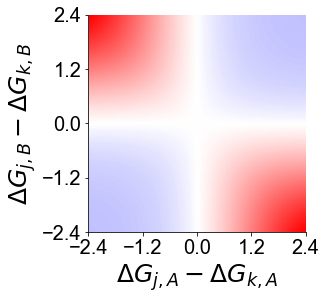

In [15]:
###################################################################################################
## define constants, energies, and mutational effects
###################################################################################################
## constants
R = 0.001987 # kcal/K*mol
T = 298.0 # K

# energy of structure i
G_i = 0
# effect of mutation A on i
dG_i_A = 0
# effect of mutation B on i
dG_i_B = 0

# energy of structure j
G_j = 0
# effect of mutation A on j
dG_j_A = 0
# effect of mutation B on j
dG_j_B = 0

# energy of structure k 
G_k = 0
# effect of mutation A on k
dG_k_A = 0
# effect of mutation B on k
dG_k_B = 0


###################################################################################################
## define perturbations (mutational effects) to be plotted
###################################################################################################
split_step_size = 0.01
split_min_value = -2.39006
split_max_value = 2.39006
split_values = np.arange(split_min_value,split_max_value+split_step_size,split_step_size)

# initialize arrays
## output = magnitude of epistasis
output = np.zeros((len(split_values),len(split_values)),dtype=np.float)
## recirpocal_ouptput = type of epistasis
reciprocal_output = np.zeros((len(split_values),len(split_values)),dtype=str)




###################################################################################################
## step through mutational effects and calculate epistasis in the observable
###################################################################################################
for x in range(len(split_values)):
    
    # set mutation_A perturb
    dG_j_A_this = dG_j_A - split_values[x]/2
    dG_k_A_this = dG_k_A + split_values[x]/2
    
    for y in range(len(split_values)):
        
        # set mutation_B perturb
        dG_j_B_this = dG_j_B - split_values[y]/2
        dG_k_B_this = dG_k_B + split_values[y]/2
        
        # calculate magnitudes and epistasis type
        mag_in_a, mag_in_b, sign_in_a, sign_in_b, ep_type = get_epistasis(G_i, G_j, G_k,             
                                                                          dG_i_A, dG_j_A_this, dG_k_A_this,
                                                                          dG_i_B, dG_j_B_this, dG_k_B_this,
                                                                          T,R)   


        reciprocal_output[y,x] = ep_type
        output[y,x] = mag_in_a
        
        
###################################################################################################
## plot it
###################################################################################################
plot_surface(output,split_values,split_values,
             xlabel="$ \Delta G_{j,A} - \Delta G_{k,A}$",
             ylabel="$ \Delta G_{j,B} - \Delta G_{k,B}$",)

plt.xlim(-2.4,2.4)
plt.xticks(np.arange(-2.4, 2.5, 1.2))
plt.yticks(np.arange(-2.4, 2.5, 1.2))

#plt.savefig('fig-4a.pdf')
plt.show()



## Section off sign vs reciprocal sign epistasis in plot above

/usr/local/Caskroom/miniconda/base/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/Caskroom/miniconda/base/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/Caskroom/miniconda/base/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Using a non-tuple sequence for multidimensional indexing is de

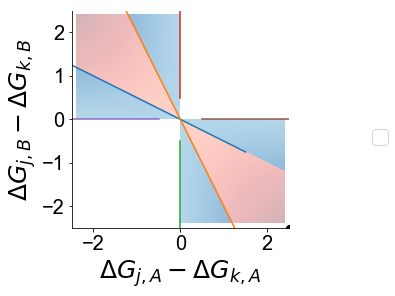

In [16]:
###################################################################################################
## mask output to get only reciprocal and sign values
###################################################################################################
## mask to remove magnitude
rmask = [reciprocal_output == ['m']]
## mask to remove sign
mask2 = [reciprocal_output == ['s']]
## set mag/sign to nan to get only reciprocal values
output_masked = np.copy(output)
output_masked[rmask] = np.nan
output_masked[mask2] = np.nan

## mask to remove magnitude
smask = [reciprocal_output == ['m']]
## mask to remove reciprocal sign
smask2 = [reciprocal_output == ['r']]
## set mag/reciprocal to nan to get only sign values
output_masked_m = np.copy(output)
output_masked_m[smask] = np.nan
output_masked_m[smask2] = np.nan


###################################################################################################
## define plot stuff
###################################################################################################
cmap = "bwr"
xlabel = "$ \Delta G_{j,A} - \Delta G_{k,A}$"
ylabel = "$ \Delta G_{j,B} - \Delta G_{k,B}$"

flip_color = True
x_array = split_values
y_array = split_values
# Flip color
if flip_color:
    plot_array = -output
    plot_array2 = -output_masked
    plot_array3 = -output_masked_m
    
else:
    plot_array = output
    plot_array2 = output_masked
    plot_array3 = output_masked_m

extreme = np.max(np.abs(plot_array))
extreme2 = np.max(np.abs(plot_array2))



###################################################################################################
## plot it
###################################################################################################
fig, ax = plt.subplots()

## plot reciprocal sign region
ax.imshow(plot_array2,origin = 'lower', 
          vmin=-extreme,vmax=extreme,cmap = 'Reds'
            , extent=[x_array[0],x_array[-1],y_array[0],y_array[-1],]
          , interpolation = 'none', visible = True, alpha = 0.3, label = 'reciprocal sign')

## plot sign epistasis region
ax.imshow(plot_array3,origin = 'lower', 
          vmin=-extreme,vmax=extreme,cmap = 'Blues'
            , extent=[x_array[0],x_array[-1],y_array[0],y_array[-1],]
          , interpolation = 'none', visible = True, alpha = 0.5, label = 'sign')
ax.scatter(2.5,-2.5, marker = 'o', color = 'black')

###################################################################################################
## plot lines to outline the reciprocal vs sign regions
###################################################################################################
def gety(lo,up,slope):
    
    return np.arange(lo,up)*slope


plt.plot(np.arange(-2.5,2.5), gety(-2.5,2.5,-0.5))
plt.plot(np.arange(-2.5,2.5), gety(-2.5,2.5,-2))

y = np.arange(-2.5,0)
plt.plot([0]*len(y), y)
plt.plot([0]*len(-y), -y)

plt.plot(y, [0]*len(y),)
plt.plot(-y, [0]*len(-y))


ax.legend(bbox_to_anchor = (1.5,0.5))
if xlabel is not None:
    ax.set_xlabel(xlabel)
ax.set_xlim(-2.5,2.5)
ax.set_ylim(-2.5,2.5)
if ylabel is not None:
    ax.set_ylabel(ylabel)

#plt.savefig('param_space_epistasis.pdf')

# Panels 4B-E: what are the energetics underlying different regions of parameter space in 4A?


+ Set $\Delta G_{j,A} - \Delta G_{k,A}$ = 0.7 kcal/mol (constant value)
+ Vary $\Delta G_{j,B} - \Delta G_{k,B}$ to explore different regions of parameter space


## Scenarios to investigate: no epistasis, magnitude, and reciprocal sign.
+ Scenario B-C: no epistasis
+ Scenario D: magnitude epistasis
+ Scenario E: reciprocal sign epistasis

## Scenario B-C: No epistasis

pop-ab, j:  0.5
pop-ab, k:  0.5 

pop-Ab, j:  0.32805015183202035
pop-Ab, k:  0.6719498481679796 

pop-aB, j:  0.5
pop-aB, k:  0.5 

pop-AB, j:  0.32805015183202035
pop-AB, k:  0.6719498481679796 

Epistasis: -2.7755575615628914e-17


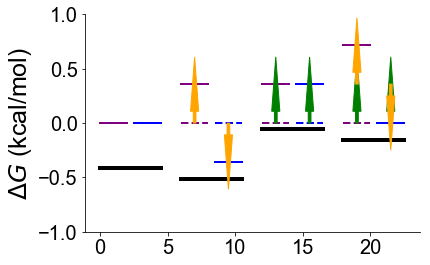

In [17]:
## no epistasis
plot_state_cycle(0,           # G_j 
                 0,           # G_k 
                 1.5/4.184,   # dG_A,j
                 -1.5/4.184,  # dG_A,k
                 1.50/4.184,  # dG_B,j
                 1.50/4.184,  # dG_B,k
                 ylim = (-1,1))
#plt.savefig("fig4BC_scenario-C.pdf")
plt.show()

## Scenario D: Magnitude epistasis

pop-ab, j:  0.5
pop-ab, k:  0.5 

pop-Ab, j:  0.32805015183202035
pop-Ab, k:  0.6719498481679796 

pop-aB, j:  0.32805015183202035
pop-aB, k:  0.6719498481679796 

pop-AB, j:  0.19247085357487365
pop-AB, k:  0.8075291464251264 

Epistasis: -0.15197164011821812


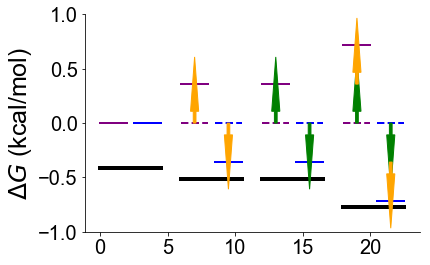

In [18]:
## magnitude epistasis
plot_state_cycle(0,            # G_j 
                 0,            # G_k 
                 1.50/4.184,   # dG_A,j
                 -1.50/4.184,  # dG_A,k
                 1.50/4.184,   # dG_B,j
                 -1.50/4.184,  # dG_B,k
                ylim = (-1,1))

#plt.savefig("fig4D_scenario-D.pdf")
plt.show()

pop-ab, j:  0.5
pop-ab, k:  0.5 

pop-Ab, j:  0.32805015183202035
pop-Ab, k:  0.6719498481679796 

pop-aB, j:  0.6719498481679796
pop-aB, k:  0.32805015183202035 

pop-AB, j:  0.5
pop-AB, k:  0.5 

Epistasis: 0.20496815699341753


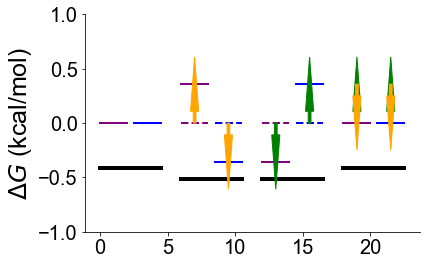

In [19]:
## reciprocal sign episatsis
plot_state_cycle(0,            # G_j 
                 0,            # G_k 
                 1.50/4.184,   # dG_A,j
                 -1.50/4.184,  # dG_A,k
                 -1.50/4.184,  # dG_B,j
                 1.50/4.184,   # dG_B,k
                ylim = (-1,1))

#plt.savefig("fig4E_scenario-E.pdf")
plt.show()